# Dota2 勝率分析

透過兩隊選擇的角色來分析勝率

![](https://steamcdn-a.akamaihd.net/steam/apps/570/header.jpg?t=1557267263)


***資料來源***
- https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results

***資料介紹***

Dota2 是5對5即時對戰遊戲，每個玩家會各自選擇不同的角色，總共有113種角色可以選擇，在此希望透過角色的選擇來預測哪個隊伍會獲勝。

***資料***
1. Team won the game (1 or -1)
2. Cluster ID (related to location)
3. Game mode (eg All Pick)
4. Game type (eg. Ranked)
5. 兩隊個選的角色(共113種，且不能重複選)


# 使用Classification
因為此資料只提供選了哪些角色，因此並不適合使用regression和clustering，因此在此使用Classification(D-tree)。

# 載入資料

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# myfont = FontProperties(fname=r'~/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf')
dota_data = pd.read_csv('dota2Train.csv')
dota_test_data = pd.read_csv('dota2Test.csv')

dota_data.describe()

,-1,223,2,2.1,0,0.1,0.2,0.3,0.4,0.5,...,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.100,0.101,0.102
count,92649.000000,92649.000000,92649.000000,92649.000000,92649.000000,92649.000000,92649.000000,92649.000000,92649.000000,92649.000000,...,92649.000000,92649.000000,92649.000000,92649.000000,92649.0,92649.000000,92649.000000,92649.000000,92649.000000,92649.000000
mean,0.053050,175.863636,3.317586,2.384591,-0.001630,-0.000971,0.000691,-0.000799,-0.002008,0.003173,...,-0.001371,-0.000950,0.000885,0.000594,0.0,0.001025,0.000648,-0.000227,-0.000043,0.000896
std,0.998597,35.658070,2.633081,0.486834,0.402006,0.467674,0.165053,0.355395,0.329349,0.483952,...,0.535027,0.206113,0.283987,0.155941,0.0,0.220704,0.204167,0.168708,0.189869,0.139034
min,-1.000000,111.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,152.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,156.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,223.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,261.000000,9.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [2]:
dota_data.head()

,-1,223,2,2.1,0,0.1,0.2,0.3,0.4,0.5,...,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.100,0.101,0.102
0,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
1,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
3,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
4,1,122,2,3,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1


# 計算每個角色上場次數和獲勝次數

In [3]:
winning_rate = np.zeros([3, 113])

percent_5 = dota_data.shape[0] / 10000 
# percent_5 = 100

for i in range (0, dota_data.shape[0]):
# for i in range (0, 100):
    for j in range (0, 113):
        # 紀錄所有角色出場次數
        if (dota_data.iloc[i, j + 4] != 0):
            winning_rate[0, j] = winning_rate[0, j] + 1
            # 紀錄所有角色獲勝次數
            if (dota_data.iloc[i, j + 4] == dota_data.iloc[i, 0]):
                winning_rate[1, j] = winning_rate[1, j] + 1
                

# 不同角色的使用次數

- 有些角色重來都沒有在比賽中被使用過
- 某幾個角色被使用的次數遠高於其他

***推論***
1. 某些角色的使用次數較高，可能是因為勝率較高所以較多人使用，因此想試著比較使用次數對勝率的關係

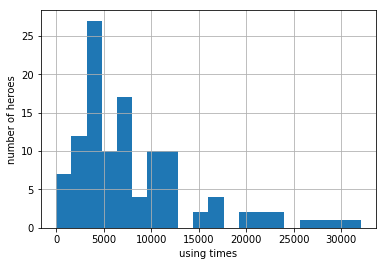

In [4]:
plt.hist(winning_rate[0], bins=20)
plt.xlabel('using times')
plt.ylabel('number of heroes')
plt.grid(True)
plt.show()

In [5]:
for i in range(0, 113): 
    if (winning_rate[0, i] == 0):
        winning_rate[2, i] = 0
    else:
        winning_rate[2, i] = 100 * winning_rate[1, i] / winning_rate[0, i]

# 英雄勝率與數量
- 從下圖可以看出遊戲在角色的平衡性上不錯，大多的角色勝率都在50%左有

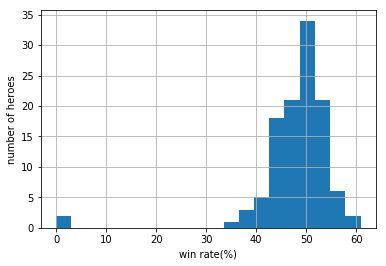

In [6]:
plt.hist(winning_rate[2], bins=20)
plt.xlabel('win rate(%)')
plt.ylabel('number of heroes')
plt.grid(True)
plt.show()

# 勝率會影響使用的次數

- 前幾個常用的角色勝率大部分 > 50%
- 最不常用的角色勝率 < 50
- 勝率最高的角色並非最常被使用的，可能是因為操作難易度高不常被使用

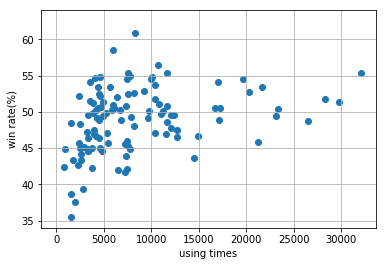

In [7]:
plt.scatter(winning_rate[0], winning_rate[2])
plt.grid(True)
plt.xlabel('using times')
plt.ylabel('win rate(%)')
plt.ylim(34, 64)
plt.show()

# 利用機率概念預測勝利隊伍 
- 利用角色勝率的平均值預測勝負
- 預測兩隊中角色勝率平均最大的隊伍獲勝

In [8]:
def win_rate_predict (win_rate, data):
    predict_correct = 0
    predict_rate = np.zeros([2, data.shape[0]])
    for i in range(0, data.shape[0]): 
#     for i in range(0, data.shape[0]):
        team1_rate = 0
        team2_rate = 0
        predict = -1 
        for j in range(0, 113):
            if (data.iloc[i, j + 4] == 1):
                team1_rate = team1_rate + win_rate[j]
                
            elif (data.iloc[i, j + 4] == -1):
                team2_rate = team2_rate + win_rate[j]
        
        predict_rate[0, i] = team1_rate
        predict_rate[1, i] = team2_rate
        
        if (team1_rate >= team2_rate):
            predict = 1
        
        if (predict == data.iloc[i, 0]):
            predict_correct = predict_correct + 1
    
    return predict_correct * 100 / data.shape[0], predict_rate
            

In [9]:
mean_train_predict, train_team_rate = win_rate_predict (winning_rate[2], dota_data)
mean_test_predict, test_team_rate = win_rate_predict (winning_rate[2], dota_test_data)

***利用平均勝率預測比賽結果***
- train data 的勝率: 59.83% 
- test data 的勝率: 59.34%

***推論***
- 遊戲設計可能不平衡(有些角色過強，有些太弱)
- 可以推測選擇角色對於勝率有影響

In [10]:
print('train accuracy: %s ' % mean_train_predict)
print('test accuracy: %s ' % mean_test_predict)

train accuracy: 59.83119083854116 
test accuracy: 59.34129991256194 


# Baseline
- 測試原始資料
- 將所有data丟入decision tree計算(不做任何更動)
- best test rate: 55.72% 

In [11]:
def best_dt(iteration, train_x, train_y, test_x, test_y):
    acc_rate = np.zeros([2, iteration])
    best_test = 0
    for i in range(1, iteration + 1):
        dtree = DecisionTreeClassifier(max_depth=i)
        dtree.fit(train_x, train_y)


        dt_train_predict = dtree.predict(train_x)
        acc_rate[0, i - 1] = accuracy_score(dt_train_predict, train_y)
        dt_test_predict = dtree.predict(test_x)
        acc_rate[1, i - 1] = accuracy_score(dt_test_predict, test_y)
        

    # draw picture
    x = list(range(1, iteration + 1))
    
    plt.plot(x, acc_rate[0], label='train')
    plt.plot(x, acc_rate[1], label='test')
    plt.xlabel('iterations')
    plt.ylabel('accuracy(%)')
    plt.grid(True)

    plt.show()
    
    return acc_rate

# 單純使用 Desicion Tree
- best train rate: 74.20%
- best test rate: 55.72%

***推論***
- 預測成功機率低於以平均來計算的勝率
- 可能是因為Desicion Tree沒有辦法計算出每個角色的勝率作為參考

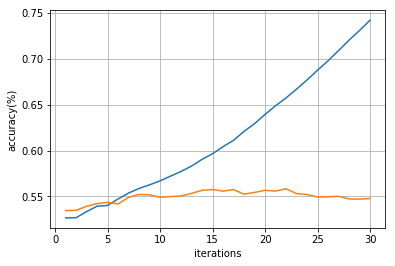

best train rate: 0.741983183844402
best test rate: 0.5582434664334985


In [12]:
train_raw_x = dota_data.drop(['-1'], axis=1)
train_raw_y = dota_data['-1']
test_raw_x = dota_test_data.drop(['-1'], axis=1)
test_raw_y = dota_test_data['-1']

acc_rate = best_dt(iteration=30, train_x=train_raw_x, train_y=train_raw_y, test_x=test_raw_x, test_y=test_raw_y)

print("best train rate: %s" % acc_rate[0].max())
print("best test rate: %s" % acc_rate[1].max())

# 刪除部份資料
- 刪除 Attribute: `Game Mode` `Game Type` `Cluster ID`

***結果***
- best train rate: 0.731891331800667
- best test rate: 0.5564947051394151

刪除後發現test data預測的結果跟沒有刪除時的一樣

***推論***

`Game Mode` `Game Type` `Cluster ID` 對勝率沒有影響


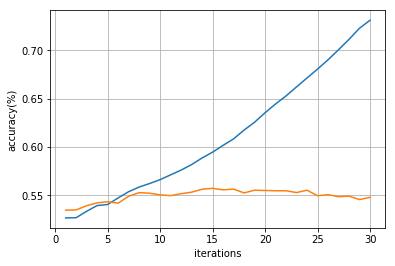

best train rate: 0.7312761065958618
best test rate: 0.5571747789760031


In [13]:
# 223	2	2.1
# 223	8	2
train_x = train_raw_x.drop(['223', '2', '2.1'], axis=1)
test_x = test_raw_x.drop(['223', '8', '2'], axis=1)
acc_rate = best_dt(iteration=30, train_x=train_x, train_y=train_raw_y, test_x=test_x, test_y=test_raw_y)
print("best train rate: %s" % acc_rate[0].max())
print("best test rate: %s" % acc_rate[1].max())

# 嘗試加入角色平均勝率

***結果***
- 預測準確率上升到 59.38%
- 當 decision tree 層數太多準確率會掉回 55% --> overfitting

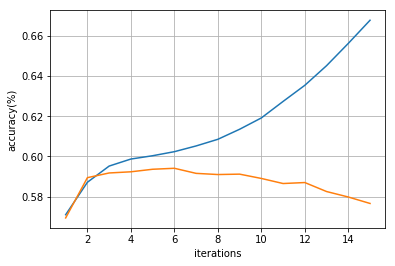

best train rate: 0.6676920420080087
best test rate: 0.5940930729622074


In [14]:
train_x['1101'] = train_team_rate[0] 
train_x['1102'] = train_team_rate[1] 
test_x['1111'] = test_team_rate[0]  
test_x['1112'] = test_team_rate[1]

acc_rate = best_dt(iteration=15, train_x=train_x, train_y=train_raw_y, test_x=test_x, test_y=test_raw_y)
print("best train rate: %s" % acc_rate[0].max())
print("best test rate: %s" % acc_rate[1].max())

# 計算不同角色合作或敵對的勝率

在遊戲中經常有角色間會互克或是某些角色可以互相搭配，因此想試著從資料中找出這些關係，希望透過這些資訊增加classifier的準確率。

***variable***
- ally_table: 儲存不同角色合作的勝率
- enemy_table: 儲存不同角色敵對的勝率

In [15]:
ally_table = np.zeros([3, 113, 113])
enemy_table = np.zeros([3, 113, 113])
for i in range(0, dota_data.shape[0]):
# for i in range(0, 1000):
    team1 = []
    team2 = []
    # team list
    for j in range(0, 113):
        query = dota_data.iloc[i, j + 4]
        if (query == 1):
            team1.append(j)
        elif (query == -1):
            team2.append(j)
        
    for j in range(0, 5):
        for k in range(0, 5):
            # ally
            ally_table[0, team1[j], team1[k]] = ally_table[0, team1[j], team1[k]] + 1
            ally_table[0, team1[k], team1[j]] = ally_table[0, team1[k], team1[j]] + 1
            ally_table[0, team2[j], team2[k]] = ally_table[0, team2[j], team2[k]] + 1
            ally_table[0, team2[k], team2[j]] = ally_table[0, team2[k], team2[j]] + 1
            
            # enemy
            enemy_table[0, team1[j], team2[k]] = enemy_table[0, team1[j], team2[k]] + 1
            enemy_table[0, team2[k], team1[j]] = enemy_table[0, team2[k], team1[j]] + 1
            
            # win case
            if (dota_data.iloc[i, 0]):
                # ally
                ally_table[1, team1[j], team1[k]] = ally_table[1, team1[j], team1[k]] + 1
                ally_table[1, team1[k], team1[j]] = ally_table[1, team1[k], team1[j]] + 1
                
                # enemy
                enemy_table[1, team1[j], team2[k]] = enemy_table[1, team1[j], team2[k]] + 1
            
            else:
                # ally
                ally_table[1, team2[j], team2[k]] = ally_table[1, team2[j], team2[k]] + 1
                ally_table[1, team2[k], team2[j]] = ally_table[1, team2[k], team2[j]] + 1
                
                # enemy
                enemy_table[1, team2[k], team1[j]] = enemy_table[1, team2[k], team1[j]] + 1
                

In [16]:
for i in range(0, 113):
    for j in range(0, 113):
        if (ally_table[0, i, j]):
            ally_table[2, i, j] = ally_table[1, i, j] / ally_table[0, i, j]
            
        if (enemy_table[0, i, j]):
            enemy_table[2, i, j] = enemy_table[1, i, j] / enemy_table[0, i, j]

In [17]:
def get_ally_enemy_predict(data, t_ally, t_enemy):
    # 0: team1 ally predict
    # 1: team2 ally predict
    # 2: team1 enemy predict
    # 3: team2 enemy predict
    predict = np.zeros([4, data.shape[0]])
    
    for i in range(0, data.shape[0]):
        team1 = []
        team2 = []
        for j in range(0, 113):
            query = data.iloc[i, j + 4]
            if (query == 1):
                team1.append(j)
            elif (query == -1):
                team2.append(j)
        
        for j in range(0, 5):
            for k in range(0, 5):
                if (j != k):
                    predict[0, i] = predict[0, i] + t_ally[team1[k], team2[j]]
                    predict[1, i] = predict[1, i] + t_ally[team2[k], team1[j]]
                
                predict[2, i] = predict[2, i] + t_enemy[team1[j], team2[k]]
                predict[3, i] = predict[3, i] + t_enemy[team2[k], team1[j]]
    
    return predict

In [18]:
train_ally_enemy_predict = get_ally_enemy_predict(dota_data, ally_table[2], enemy_table[2])
test_ally_enemy_predict = get_ally_enemy_predict(dota_test_data, ally_table[2], enemy_table[2])

In [19]:
train_x['00010'] = train_ally_enemy_predict[0]
train_x['00011'] = train_ally_enemy_predict[1]
train_x['00012'] = train_ally_enemy_predict[2]
train_x['00013'] = train_ally_enemy_predict[3]

test_x['00020'] = test_ally_enemy_predict[0]
test_x['00021'] = test_ally_enemy_predict[1]
test_x['00022'] = test_ally_enemy_predict[2]
test_x['00023'] = test_ally_enemy_predict[3]

# 利用角色之間的關係預測
- 準確率: 59.44%
- 加入角色之間的關係後的結果不如預期，其準確率只比原本的增加了一點點

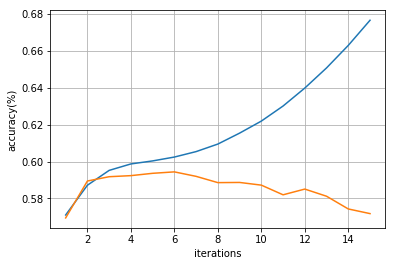

best train rate: 0.6766182041900074
best test rate: 0.5943845331778879


In [20]:
acc_rate = best_dt(iteration=15, train_x=train_x, train_y=train_raw_y, test_x=test_x, test_y=test_raw_y)
print("best train rate: %s" % acc_rate[0].max())
print("best test rate: %s" % acc_rate[1].max())

# 結論
- 最後預測最好的結果為59%

***個人想法***

目前的電競遊戲主要看中的是選手的操作技術，會盡量讓角色間的平衡性不會差太多，但在這個資料中沒有紀錄選手的數據。雖然透過角色的選擇我們可以判斷對那方比較有利，但最終還是必須透過選手的技術與戰術來決定輸贏。